# Tugas Proyek Akhir Microcredential Data Science

# Analisis Prediksi Tingkat Curah Hujan Berdasarkan Data-data Sebelumnya

Kondisi cuaca merupakan hal penting yang perlu dipelajari karena cuaca di suatu daerah menentukan rangkaian aktifitas manusia. Sebagai contoh, informasi iklim dan klasifikasinya banyak menjadi acuan untuk bidang pertanian, transportasi, dan pariwisata seperti: pelayaran, penerbangan, dan masa pola tanam. Maka dari itu pengamatan terhadap kondisi cuaca, khususnya kondisi curah hujan sangat penting dilakukan.

Besarnya curah hujan yang terjadi tidak dapat ditentukan secara pasti, namun dapat diprediksi atau diperkirakan. Dengan menggunakan data historis besarnya curah hujan beberapa waktu yang lampau, maka dapat diprediksi berapa besarnya curah hujan yang terjadi pada masa yang akan datang. Banyak cara yang dapat dilakukan untuk memprediksi besarnya curah hujan di suatu
tempat, salah satunya adalah menggunakan teknik regresi.

Dengan menggunakan data-data historis dari curah hujan yang lalu dan beberapa parameter data seperti tahun, tekanan udara, penyinaran matahari, kecepatan angin, kelembapan dan suhu maka prediksi curah hujan dapat dilakukan.

Data diambil dari website resmi Badan Pusat Statistik mengenai iklim Indonesia
yang berupa :
- Jumlah Curah Hujan dan Jumlah Hari Hujan di Stasiun Pengamatan BMKG, 2011-2015 (https://www.bps.go.id/statictable/2017/02/08/1959/jumlah-curahhujan-dan-jumlah-hari-hujan-di-stasiun-pengamatan-bmkg-2011-2015.html)
- Tekanan Udara dan Penyinaran Matahari di Stasiun Pengamatan BMKG, 2011-2015 (https://www.bps.go.id/statictable/2017/02/09/1962/tekanan-udaradan-penyinaran-matahari-di-stasiun-pengamatan-bmkg-2011-2015.html)
- Kecepatan Angin dan Kelembaban di Stasiun Pengamatan BMKG, 2011-2015 (https://www.bps.go.id/statictable/2017/02/08/1960/kecepatanangin-dan-kelembaban-di-stasiun-pengamatan-bmkg-2011-2015.html)
- Suhu Minimum, Rata-Rata, dan Maksimum di Stasiun Pengamatan BMKG (oC), 2011-2015
(https://www.bps.go.id/statictable/2017/02/09/1961/suhu-minimumrata-rata-dan-maksimum-di-stasiun-pengamatan-bmkg-oc-2011-2015.html)

Berikut proses prediksi yang dilakukan

# Import Library

In [1]:
# basic computing
import pandas as pd
import numpy as np

# visualizing
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# modelling
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# evaluating
import sklearn.metrics as metrics

# Load dan Explorasi data

karena data yang diambil dari beberapa sumber file yang berbeda dan memiliki strukturnya tersendiri maka dibutuhkan fungsi khusus yang akan memproses pengambilan data tersebut sekaligus merapikan datanya

In [2]:
def create_df(da, year=[]):
  data = da.copy()
  nd = pd.DataFrame()
  data.drop(["Provinsi","Stasiun BMKG"], axis=1, inplace=True)
  length = int(data.shape[1]/5)
  col_names = data.columns[0:length]
  for i in range(0,5):
    val  = data.iloc[:,0:length]
    d = dict(zip(val.columns[0::1],  col_names))
    val = val.rename(columns=d)
    if(len(year)>0):
      val["year"] = year[i]
    nd = nd.append(val, ignore_index=True)
    data.drop(data.columns[0:length], axis=1, inplace=True)
  return nd

In [3]:
da1 = create_df(pd.read_excel("data/Indo_151_15887472.xls"))
da2 = create_df(pd.read_excel("data/Indo_151_17952722.xls"))
da3 = create_df(pd.read_excel("data/Indo_151_18467275.xls"))
da4 = create_df(pd.read_excel("data/Indo_151_21445257.xls"),  year = [2011,2012,2013,2014,2015])

In [4]:
da_list = [da1,da2,da3,da4]
data_cuaca = pd.concat(da_list, axis=1, join="inner")
col = ['tekanan_udara', 'penyinaran_matahari', 'suhu_minimum', 'suhu_rata_rata', 'suhu_maksimum', 'curah_hujan', 'hari_hujan', 'kecepatan_angin', 'kelembaban', 'tahun']
data_cuaca.columns = col

In [5]:
data_cuaca = data_cuaca[['tahun', 'tekanan_udara', 'penyinaran_matahari', 'suhu_minimum', 'suhu_rata_rata', 'suhu_maksimum', 'kecepatan_angin', 'kelembaban', 'hari_hujan', 'curah_hujan']]
data_cuaca

,tahun,tekanan_udara,penyinaran_matahari,suhu_minimum,suhu_rata_rata,suhu_maksimum,kecepatan_angin,kelembaban,hari_hujan,curah_hujan
0,2011,1009.4,52.20,22.4,27.1,34.4,4.90,79.4,150.0,1268.0
1,2011,NaN,44.40,21.7,27.2,36.0,1.80,79.0,225.0,2042.0
2,2011,990.8,32.80,15.6,NaN,34.2,0.50,54.2,NaN,NaN
3,2011,1008.7,42.30,19.9,27.0,35.8,5.40,74.5,211.0,2405.0
4,2011,1010.2,54.10,21.0,26.9,34.8,5.50,82.5,209.0,2295.0
...,...,...,...,...,...,...,...,...,...,...
165,2015,1012.5,78.00,20.4,27.9,35.6,1.93,77.2,93.0,1167.9
166,2015,1012.4,66.52,20.1,26.5,35.3,2.35,83.6,167.0,1987.2
167,2015,1013.0,84.07,21.6,27.3,34.2,2.60,78.3,127.0,913.4
168,2015,1011.5,61.63,21.8,27.4,33.8,1.54,83.6,218.0,2844.6


In [6]:
data_cuaca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tahun                170 non-null    int64  
 1   tekanan_udara        158 non-null    float64
 2   penyinaran_matahari  159 non-null    float64
 3   suhu_minimum         163 non-null    float64
 4   suhu_rata_rata       158 non-null    float64
 5   suhu_maksimum        162 non-null    float64
 6   kecepatan_angin      159 non-null    float64
 7   kelembaban           162 non-null    float64
 8   hari_hujan           155 non-null    float64
 9   curah_hujan          162 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 13.4 KB


In [7]:
print("Ukuran data yang diperoleh :", data_cuaca.shape)

Ukuran data yang diperoleh : (170, 10)


# Menghapus duplicated data

In [8]:
col_duplicated = ['tekanan_udara','penyinaran_matahari','suhu_minimum','suhu_rata_rata','suhu_maksimum','kecepatan_angin','kelembaban','hari_hujan','curah_hujan']
data_cuaca[data_cuaca.duplicated(subset=col_duplicated,keep=False)]

,tahun,tekanan_udara,penyinaran_matahari,suhu_minimum,suhu_rata_rata,suhu_maksimum,kecepatan_angin,kelembaban,hari_hujan,curah_hujan
6,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data_drop_duplicated =  data_cuaca.drop_duplicates(subset=col_duplicated,keep=False)
print("Ukuran data yang setelah duplicate data dihapus :", data_drop_duplicated.shape)

Ukuran data yang setelah duplicate data dihapus : (164, 10)


# Handling Missing Value

In [10]:
data_drop_duplicated.isna().sum()

tahun                  0
tekanan_udara          6
penyinaran_matahari    5
suhu_minimum           1
suhu_rata_rata         6
suhu_maksimum          2
kecepatan_angin        5
kelembaban             2
hari_hujan             9
curah_hujan            2
dtype: int64

In [11]:
data_drop_duplicated[data_drop_duplicated.isna().any(axis=1)]

,tahun,tekanan_udara,penyinaran_matahari,suhu_minimum,suhu_rata_rata,suhu_maksimum,kecepatan_angin,kelembaban,hari_hujan,curah_hujan
1,2011,NaN,44.40,21.7,27.20,36.0,1.80,79.00,225.0,2042.0
2,2011,990.80,32.80,15.6,NaN,34.2,0.50,54.20,NaN,NaN
10,2011,1009.50,60.90,23.4,28.50,35.4,2.40,74.30,NaN,1274.0
14,2011,1010.10,69.10,20.0,NaN,34.8,7.20,71.50,NaN,1790.0
17,2011,1009.70,68.00,20.7,NaN,32.5,7.00,80.10,NaN,NaN
20,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,218.0,3434.6
21,2011,968.00,NaN,20.4,27.10,36.0,5.30,81.80,195.0,2751.0
25,2011,1009.90,54.40,22.8,27.60,34.1,1.80,76.10,NaN,667.0
27,2011,NaN,NaN,22.0,NaN,33.0,2.00,84.00,121.0,1511.0
35,2012,NaN,48.00,21.0,27.30,36.9,0.60,76.00,227.0,3175.0


menghapus nilai NaN pada kolom curah_hujan (target)

In [12]:
data_drop_null = data_drop_duplicated.dropna(subset=['curah_hujan'])

In [13]:
data_drop_null.isna().sum()

tahun                  0
tekanan_udara          6
penyinaran_matahari    5
suhu_minimum           1
suhu_rata_rata         4
suhu_maksimum          2
kecepatan_angin        5
kelembaban             2
hari_hujan             7
curah_hujan            0
dtype: int64

In [14]:
data_drop_null[data_drop_null.isna().any(axis=1)]

,tahun,tekanan_udara,penyinaran_matahari,suhu_minimum,suhu_rata_rata,suhu_maksimum,kecepatan_angin,kelembaban,hari_hujan,curah_hujan
1,2011,NaN,44.40,21.7,27.20,36.0,1.80,79.00,225.0,2042.0
10,2011,1009.50,60.90,23.4,28.50,35.4,2.40,74.30,NaN,1274.0
14,2011,1010.10,69.10,20.0,NaN,34.8,7.20,71.50,NaN,1790.0
20,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,218.0,3434.6
21,2011,968.00,NaN,20.4,27.10,36.0,5.30,81.80,195.0,2751.0
25,2011,1009.90,54.40,22.8,27.60,34.1,1.80,76.10,NaN,667.0
27,2011,NaN,NaN,22.0,NaN,33.0,2.00,84.00,121.0,1511.0
35,2012,NaN,48.00,21.0,27.30,36.9,0.60,76.00,227.0,3175.0
48,2012,1010.00,75.00,20.6,28.00,35.4,13.30,NaN,NaN,1389.0
59,2012,1010.30,62.80,23.1,27.70,35.0,3.80,76.00,NaN,760.0


Melakukan imputasi data pada missing value di kolom prediktor

In [15]:
missing_columns = data_drop_null.drop(["tahun","curah_hujan"], axis=1).columns
clean = data_drop_null.loc[:,["tahun","curah_hujan"]]

In [76]:
def random_imputation(df, feature):
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

In [77]:
for feature in missing_columns:
    data_drop_null[feature + '_imp'] = data_drop_null[feature]
    data_drop_null = random_imputation(data_drop_null, feature)

In [78]:
deter_data = pd.DataFrame(columns = [name for name in missing_columns])

for feature in missing_columns:
        
    deter_data[feature] = data_drop_null[feature + "_imp"]
    parameters = list(set(data_drop_null.columns) - set(missing_columns) - {feature + '_imp'})
    
    model = LinearRegression()
    model.fit(X = data_drop_null[parameters], y = data_drop_null[feature + '_imp'])
    
    deter_data.loc[data_drop_null[feature].isnull(), feature] = model.predict(data_drop_null[parameters])[data_drop_null[feature].isnull()]

In [79]:
deter_data

,tekanan_udara,penyinaran_matahari,suhu_minimum,suhu_rata_rata,suhu_maksimum,kecepatan_angin,kelembaban,hari_hujan
0,1009.400000,52.20,22.4,27.1,34.4,4.90,79.4,150.0
1,1006.645665,44.40,21.7,27.2,36.0,1.80,79.0,225.0
3,1008.700000,42.30,19.9,27.0,35.8,5.40,74.5,211.0
4,1010.200000,54.10,21.0,26.9,34.8,5.50,82.5,209.0
5,1009.600000,54.00,23.4,27.3,34.6,2.70,84.8,217.0
...,...,...,...,...,...,...,...,...
165,1012.500000,78.00,20.4,27.9,35.6,1.93,77.2,93.0
166,1012.400000,66.52,20.1,26.5,35.3,2.35,83.6,167.0
167,1013.000000,84.07,21.6,27.3,34.2,2.60,78.3,127.0
168,1011.500000,61.63,21.8,27.4,33.8,1.54,83.6,218.0


In [80]:
data_drop_null = pd.concat([clean, deter_data], axis=1)
data_drop_null

,tahun,curah_hujan,tekanan_udara,penyinaran_matahari,suhu_minimum,suhu_rata_rata,suhu_maksimum,kecepatan_angin,kelembaban,hari_hujan
0,2011,1268.0,1009.400000,52.20,22.4,27.1,34.4,4.90,79.4,150.0
1,2011,2042.0,1006.645665,44.40,21.7,27.2,36.0,1.80,79.0,225.0
3,2011,2405.0,1008.700000,42.30,19.9,27.0,35.8,5.40,74.5,211.0
4,2011,2295.0,1010.200000,54.10,21.0,26.9,34.8,5.50,82.5,209.0
5,2011,2593.0,1009.600000,54.00,23.4,27.3,34.6,2.70,84.8,217.0
...,...,...,...,...,...,...,...,...,...,...
165,2015,1167.9,1012.500000,78.00,20.4,27.9,35.6,1.93,77.2,93.0
166,2015,1987.2,1012.400000,66.52,20.1,26.5,35.3,2.35,83.6,167.0
167,2015,913.4,1013.000000,84.07,21.6,27.3,34.2,2.60,78.3,127.0
168,2015,2844.6,1011.500000,61.63,21.8,27.4,33.8,1.54,83.6,218.0


# Handling Outlier

permasalahan outlier diselesaikan dengan menggunakan metode winsorize yaitu menggeser nilai yang oulier ke dalam quartile data

In [21]:
data_drop_null.describe()

,tahun,curah_hujan,tekanan_udara,penyinaran_matahari,suhu_minimum,suhu_rata_rata,suhu_maksimum,kecepatan_angin,kelembaban,hari_hujan
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,2013.067901,2298.672840,1006.954416,59.137645,21.442099,27.008484,34.340573,3.814047,80.576513,182.458811
std,1.410372,835.757699,15.711808,11.970379,2.020229,0.911201,1.758389,2.455706,3.907215,42.680784
min,2011.000000,460.900000,922.100000,22.900000,14.400000,23.400000,30.100000,0.070000,70.000000,68.000000
25%,2012.000000,1682.275000,1009.300000,50.625000,20.425000,26.800000,33.100000,2.305000,78.100000,154.250000
50%,2013.000000,2267.200000,1010.127027,58.915000,21.600000,27.100000,34.200000,3.325000,81.000000,178.500000
75%,2014.000000,2832.400000,1011.200000,67.620000,23.000000,27.400000,35.575000,4.500000,83.595000,217.000000
max,2015.000000,5041.000000,1023.326206,85.050000,26.000000,28.770000,40.300000,19.250000,97.800000,276.000000


In [22]:
# show boxplot
def boxplot_feature(data):
    fig, ax = plt.subplots(4, 2, figsize=(16,10))

    sns.boxplot(data=data, x='tekanan_udara', ax=ax[0][0])
    sns.boxplot(data=data, x='penyinaran_matahari', ax=ax[0][1])

    sns.boxplot(data=data, x='suhu_minimum', ax=ax[1][0])
    sns.boxplot(data=data, x='suhu_rata_rata', ax=ax[1][1])

    sns.boxplot(data=data, x='suhu_maksimum', ax=ax[2][0])
    sns.boxplot(data=data, x='kecepatan_angin', ax=ax[2][1])

    sns.boxplot(data=data, x='kelembaban', ax=ax[3][0])
    sns.boxplot(data=data, x='hari_hujan', ax=ax[3][1])

In [23]:
# defining outlier boundaries
def find_outlier(df, variable_name):    
    q1 = df[variable_name].quantile(0.25)
    q3 = df[variable_name].quantile(0.75)
    iqr = q3-q1
    outer_fence = 3*iqr
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    return outer_fence_le, outer_fence_ue

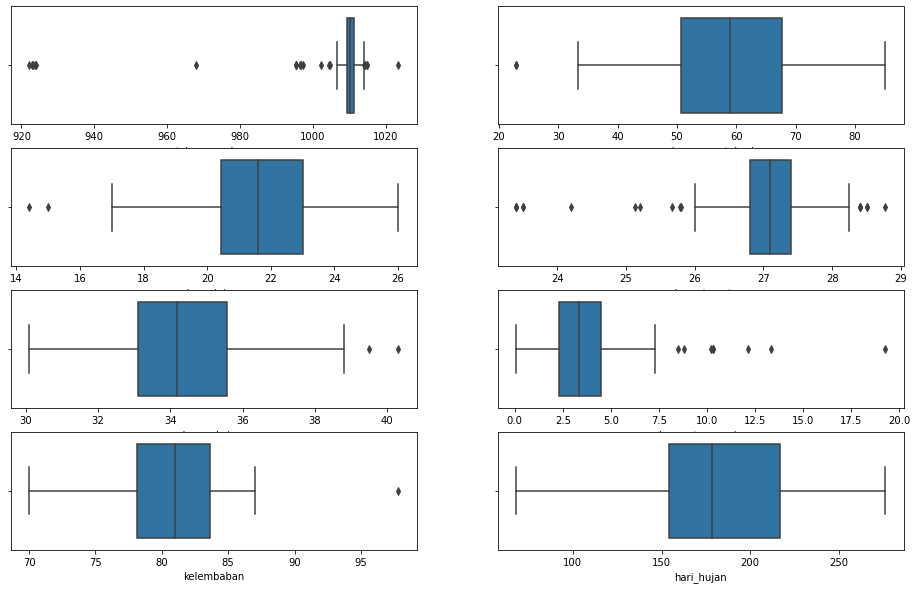

In [24]:
boxplot_feature(data_drop_null)

In [25]:
data_outlier = data_drop_null.copy()
col_outlier = data_outlier.drop(['tahun', 'curah_hujan'], axis=1).columns
col_outlier

Index(['tekanan_udara', 'penyinaran_matahari', 'suhu_minimum',
       'suhu_rata_rata', 'suhu_maksimum', 'kecepatan_angin', 'kelembaban',
       'hari_hujan'],
      dtype='object')

In [26]:
for col in col_outlier:
    outer_fence_le, outer_fence_ue = find_outlier(data_outlier, col)
#     dt_wn_win = winsorize(data_outlier[col], limits=(0.025, 0.025))
#     data_outlier[col] = dt_wn_win
    data_outlier[col] = np.where(data_outlier[col] < outer_fence_le, outer_fence_le,
                                np.where(data_outlier[col] > outer_fence_ue, outer_fence_ue, data_outlier[col]))

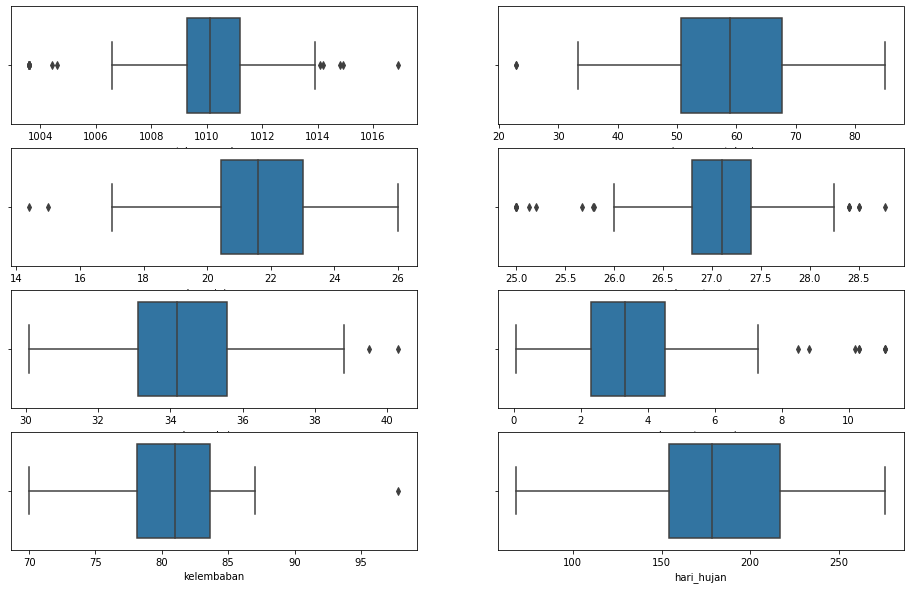

In [27]:
boxplot_feature(data_outlier)

# Seleksi Fitur

<AxesSubplot:>

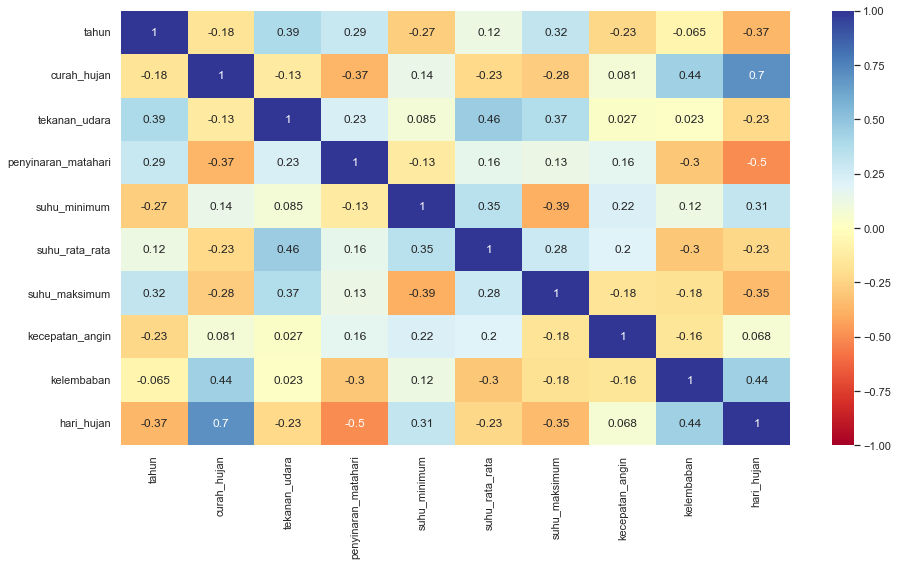

In [28]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(data_outlier.corr(), vmin=-1, vmax=1, annot=True, cmap='RdYlBu')

<Figure size 1152x576 with 0 Axes>

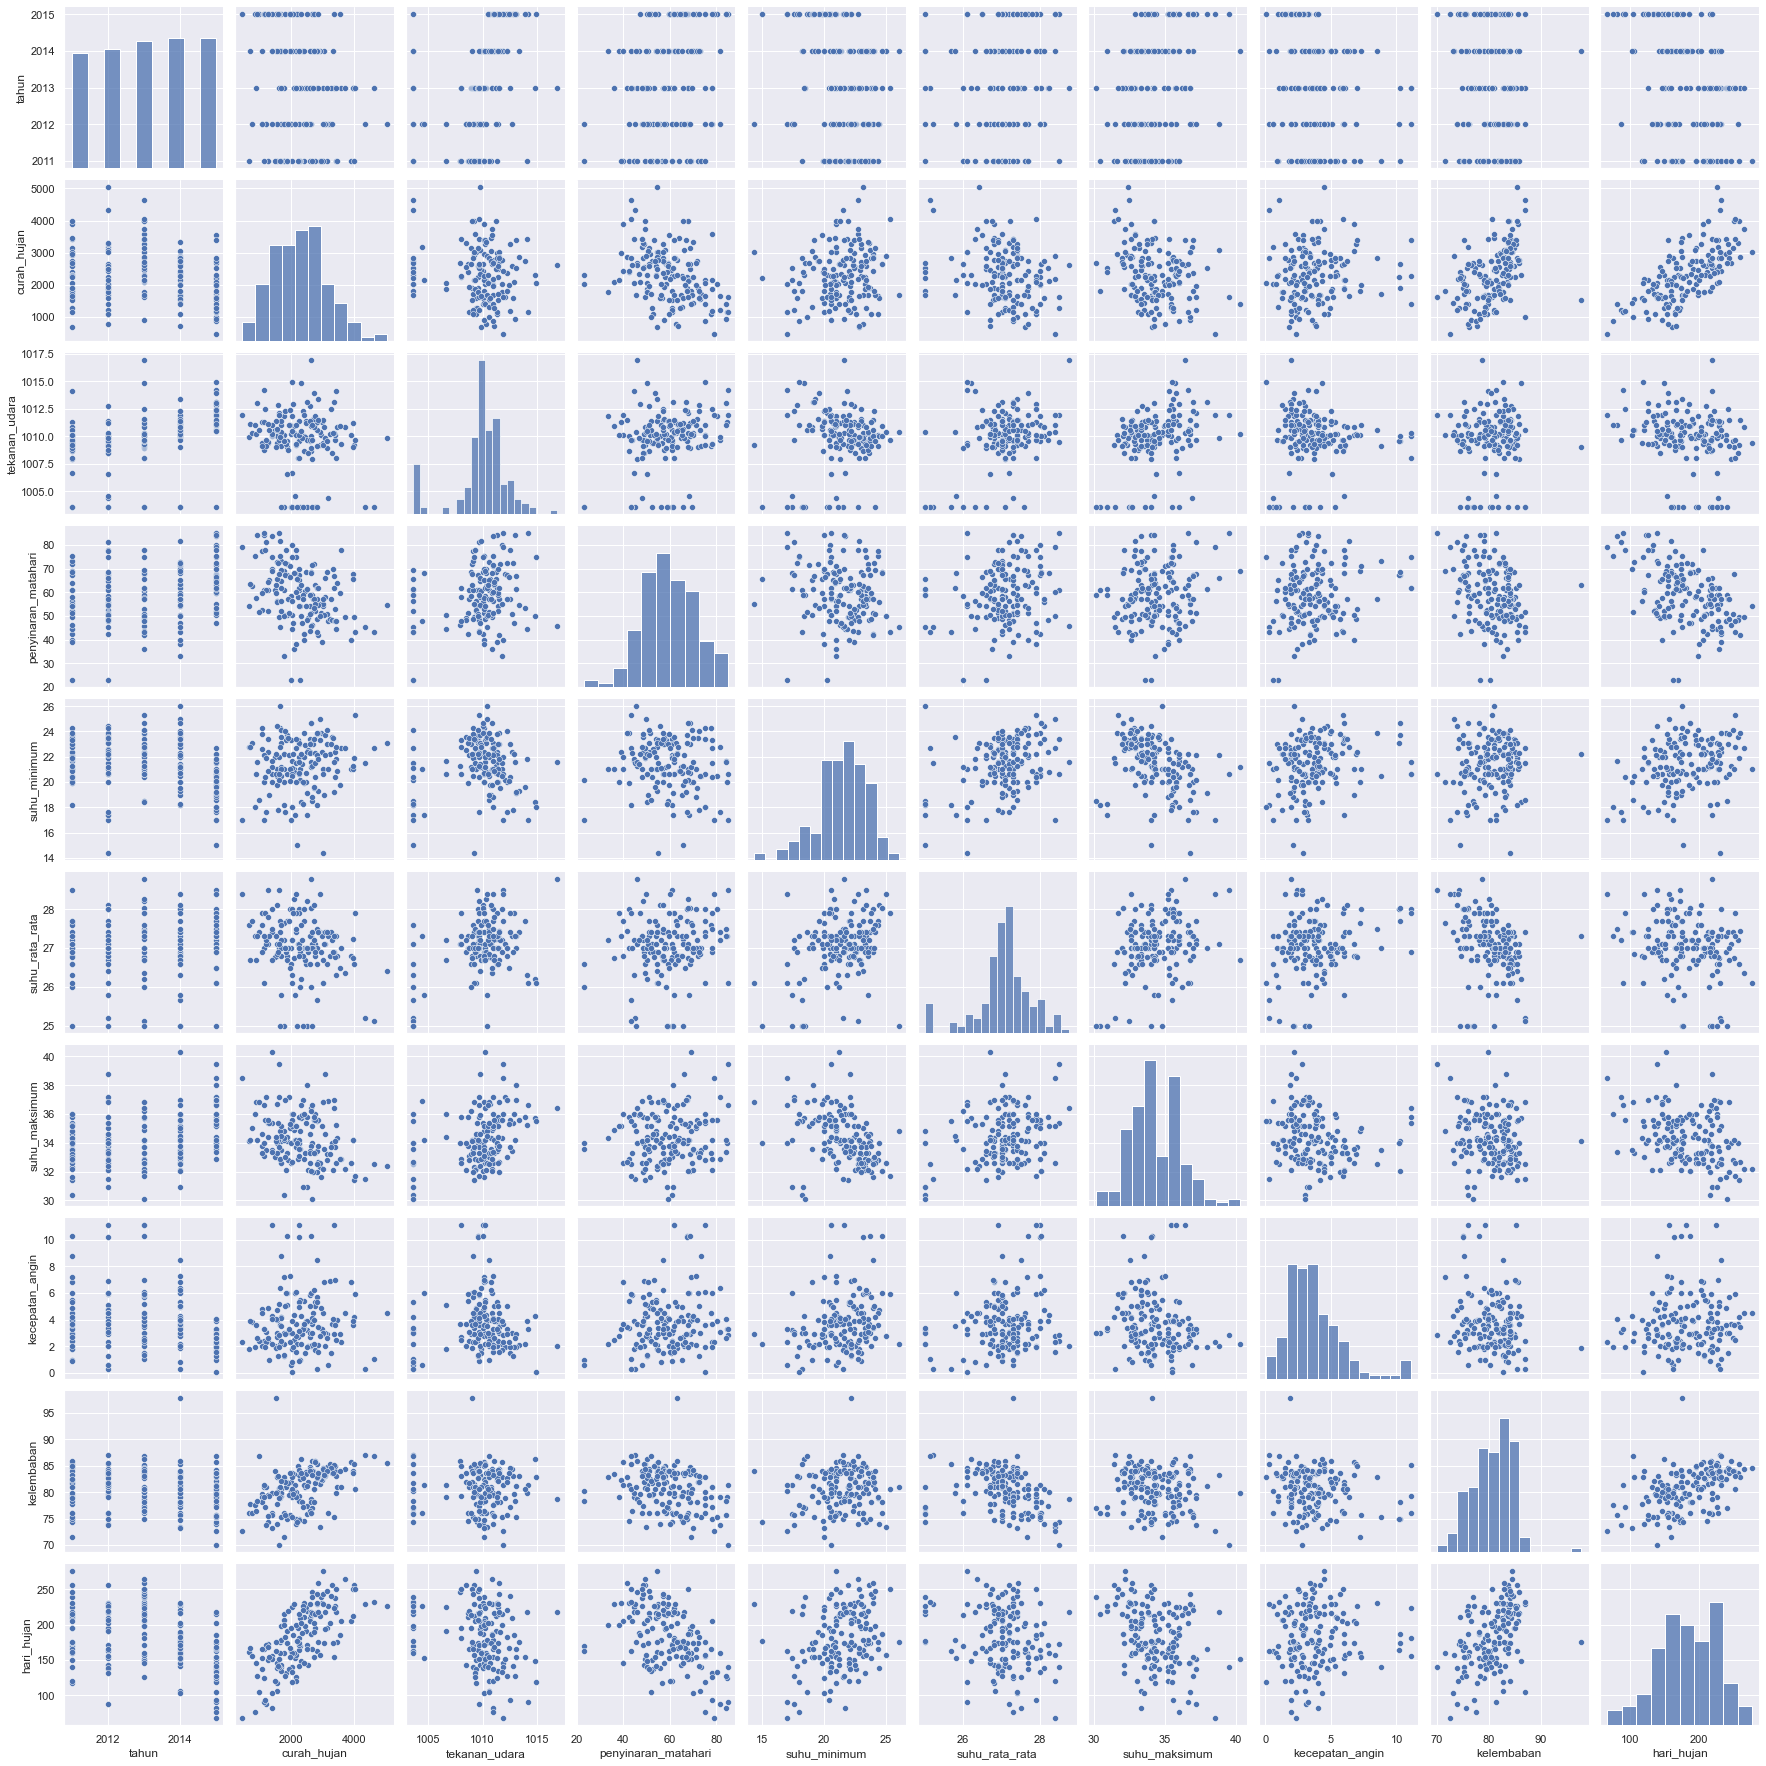

In [29]:
plt.figure(figsize=(16,8))
sns.pairplot(data=data_outlier)

variabel fitur diambil dari nilai korelasi yang tinggi terhadap data target

In [30]:
data_selection = data_outlier.copy()
data_selection = data_selection[["penyinaran_matahari", "suhu_rata_rata", "kelembaban", "hari_hujan", "curah_hujan"]]
data_selection.head()

,penyinaran_matahari,suhu_rata_rata,kelembaban,hari_hujan,curah_hujan
0,52.2,27.1,79.4,150.0,1268.0
1,44.4,27.2,79.0,225.0,2042.0
3,42.3,27.0,74.5,211.0,2405.0
4,54.1,26.9,82.5,209.0,2295.0
5,54.0,27.3,84.8,217.0,2593.0


# Preprocessing

proses persiapan data dilakukan dengan standarisasi data dan splitting data sebelum masuk dalam training model

In [31]:
scaler = StandardScaler() 
data_scaled = scaler.fit_transform(data_selection)

In [32]:
data_scaled[:5]

array([[-0.58136482,  0.05278938, -0.30204675, -0.7628599 , -1.23704362],
       [-1.23499379,  0.19015481, -0.4047389 ,  0.99981997, -0.30806623],
       [-1.41097081, -0.08457605, -1.56002563,  0.6707864 ,  0.12761696],
       [-0.42214751, -0.22194149,  0.49381744,  0.6237816 , -0.00440825],
       [-0.43052737,  0.32752024,  1.08429732,  0.81180079,  0.35326005]])

In [33]:
X = data_scaled[:, :-1]
y = data_scaled[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state=3)

visualisasi data dengan mereduksi fitur menjadi 1 fitur komponen

<AxesSubplot:>

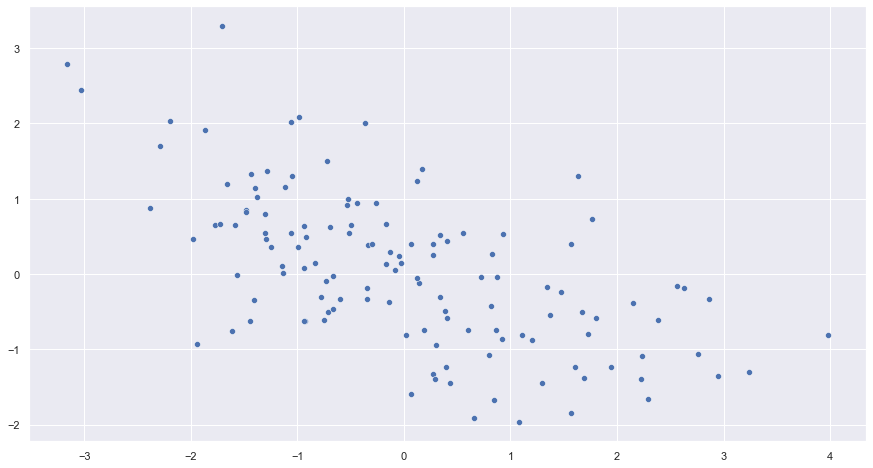

In [34]:
model_pca = PCA(n_components=1)
X_train_reduction = model_pca.fit_transform(X_train)
sns.scatterplot(x=X_train_reduction.T[0], y=y_train)

# Tune Parameter with Multiple Models 

beberapa percobaan model yang akan digunakan yaitu :
- Linear Regression
- Polynomial Regression
- Support Vector Machine
- Random Forest
- Gradient Boosting

### Linear Regression

In [35]:
lin_reg = LinearRegression().fit(X_train, y_train)

In [36]:
lin_reg_pred = lin_reg.predict(X_test)

lin_reg_mae = metrics.mean_absolute_error(y_test, lin_reg_pred)
lin_reg_mse = metrics.mean_squared_error(y_test, lin_reg_pred)
lin_reg_rmse = np.sqrt(lin_reg_mse) 
lin_reg_r2 = metrics.r2_score(y_test, lin_reg_pred)

print("Results of linear regression")
print("MAE:",lin_reg_mae)
print("MSE:", lin_reg_mse)
print("RMSE:", lin_reg_rmse)
print("R-Squared:", lin_reg_r2)

Results of linear regression
MAE: 0.4154313842060864
MSE: 0.2648324426169261
RMSE: 0.514618735198133
R-Squared: 0.6586902708376591


### Polynomial Regression

In [37]:
pol_reg = make_pipeline(PolynomialFeatures(), LinearRegression()).fit(X_train, y_train)

In [38]:
pol_reg_pred = pol_reg.predict(X_test)

pol_reg_mae = metrics.mean_absolute_error(y_test, pol_reg_pred)
pol_reg_mse = metrics.mean_squared_error(y_test, pol_reg_pred)
pol_reg_rmse = np.sqrt(pol_reg_mse) 
pol_reg_r2 = metrics.r2_score(y_test, pol_reg_pred)

print("Results of polynomial regression")
print("MAE:",pol_reg_mae)
print("MSE:", pol_reg_mse)
print("RMSE:", pol_reg_rmse)
print("R-Squared:", pol_reg_r2)

Results of polynomial regression
MAE: 0.4702594045227867
MSE: 0.32671395942288883
RMSE: 0.5715889776954143
R-Squared: 0.5789388494011674


### Support Vector Machine 

In [39]:
svr_params = {'kernel': ['poly', 'rbf', 'linear'],
              'C': [0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10],
              'gamma': [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
              'degree': [1, 2, 3]}
svr = GridSearchCV(estimator=SVR(), param_grid=svr_params, cv=4)
svr.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=SVR(),
             param_grid={'C': [0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10],
                         'degree': [1, 2, 3],
                         'gamma': [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
                         'kernel': ['poly', 'rbf', 'linear']})

In [40]:
print("parameter terbaik dari model support vector machine :", svr.best_estimator_)
print("score validation terbaik dari model support vector machine :", svr.best_score_)

parameter terbaik dari model support vector machine : SVR(C=3, degree=1, gamma=0.06)
score validation terbaik dari model support vector machine : 0.43270048804099515


In [41]:
svr_pred = svr.predict(X_test)

svr_mae = metrics.mean_absolute_error(y_test, svr_pred)
svr_mse = metrics.mean_squared_error(y_test, svr_pred)
svr_rmse = np.sqrt(svr_mse) 
svr_r2 = metrics.r2_score(y_test, svr_pred)

print("Results of support vector machine")
print("MAE:",svr_mae)
print("MSE:", svr_mse)
print("RMSE:", svr_rmse)
print("R-Squared:", svr_r2)

Results of support vector machine
MAE: 0.48213889428313816
MSE: 0.3362690944479732
RMSE: 0.5798871394055685
R-Squared: 0.5666244195099683


### Random Forest

In [42]:
rf_params = {'bootstrap': [False, True], 'max_depth': [1, 2, 5, 10, 20, 30, 50, 70, 100, 150, None], 
             'max_features': ['auto', 'log2', 'sqrt'], 
             'n_estimators': [5, 10, 20, 50, 100, 150, 200, 300, 500]}
rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rf_params, cv=4)
rf.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [False, True],
                         'max_depth': [1, 2, 5, 10, 20, 30, 50, 70, 100, 150,
                                       None],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'n_estimators': [5, 10, 20, 50, 100, 150, 200, 300,
                                          500]})

In [43]:
print("estimator terbaik dari model random forest :", rf.best_estimator_)
print("score validation terbaik dari model random forest :", rf.best_score_)

estimator terbaik dari model random forest : RandomForestRegressor(max_depth=150, max_features='log2', n_estimators=10)
score validation terbaik dari model random forest : 0.5042314081553801


In [44]:
rf_pred = rf.predict(X_test)

rf_mae = metrics.mean_absolute_error(y_test, rf_pred)
rf_mse = metrics.mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse) 
rf_r2 = metrics.r2_score(y_test, rf_pred)

print("Results of random forest")
print("MAE:",rf_mae)
print("MSE:", rf_mse)
print("RMSE:", rf_rmse)
print("R-Squared:", rf_r2)

Results of random forest
MAE: 0.547195760418061
MSE: 0.4502746032349228
RMSE: 0.6710250392011633
R-Squared: 0.4196968416702216


### Gradient Boosting

In [45]:
gbm_params = {'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.3, 0.6],
              'subsample'    : [1, 0.6, 0.3, 0.1],
              'n_estimators' : [10, 20, 50, 100, 300, 600],
              'max_depth'    : [1, 2, 3, 4]}
gbm = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=gbm_params, cv=4)
gbm.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.3,
                                           0.6],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [10, 20, 50, 100, 300, 600],
                         'subsample': [1, 0.6, 0.3, 0.1]})

In [46]:
print("estimator terbaik dari model gradient boosting :", gbm.best_estimator_)
print("score validation terbaik dari model gradient boosting :", gbm.best_score_)

estimator terbaik dari model gradient boosting : GradientBoostingRegressor(learning_rate=0.06, max_depth=2, n_estimators=50,
                          subsample=0.3)
score validation terbaik dari model gradient boosting : 0.49452220160364285


In [71]:
gbm_pred = gbm.predict(X_test)

gbm_mae = metrics.mean_absolute_error(y_test, gbm_pred)
gbm_mse = metrics.mean_squared_error(y_test, gbm_pred)
gbm_rmse = np.sqrt(gbm_mse) 
gbm_r2 = metrics.r2_score(y_test, gbm_pred)

print("Results of gradient boosting")
print("MAE:", gbm_mae)
print("MSE:", gbm_mse)
print("RMSE:", gbm_rmse)
print("R-Squared:", gbm_r2)

Results of gradient boosting
MAE: 0.4998806457315422
MSE: 0.3720945941598548
RMSE: 0.609995568967394
R-Squared: 0.5204533708161542


# Select Model

In [72]:
data_score = pd.DataFrame({"1-MAE": [1-lin_reg_mae, 1-pol_reg_mae, 1-svr_mae, 1-rf_mae, 1-gbm_mae],
                          "1-MSE": [1-lin_reg_mse, 1-pol_reg_mse, 1-svr_mse, 1-rf_mse, 1-gbm_mse],
                          "1-RMSE": [1-lin_reg_rmse, 1-pol_reg_rmse, 1-svr_rmse, 1-rf_rmse, 1-gbm_rmse],
                          "R2 Score": [lin_reg_r2, pol_reg_r2, svr_r2, rf_r2, gbm_r2]}, 
                          index=['Linear Regression', 'Polynomial Regression', 'Support Vector Machine', 'Random Forest', 'Gradient Boosting'])
data_score

,1-MAE,1-MSE,1-RMSE,R2 Score
Linear Regression,0.584569,0.735168,0.485381,0.658690
Polynomial Regression,0.529741,0.673286,0.428411,0.578939
Support Vector Machine,0.517861,0.663731,0.420113,0.566624
Random Forest,0.452804,0.549725,0.328975,0.419697
Gradient Boosting,0.500119,0.627905,0.390004,0.520453


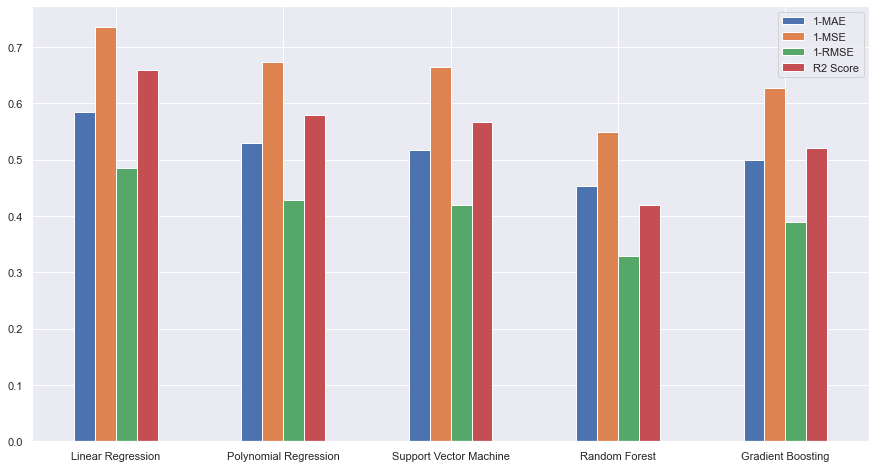

In [75]:
data_score.plot.bar()
plt.xticks(rotation=0)
plt.show()

kesimpulan dari proses training model yang telah dibangun, Linear Regression memiliki nilai metrik evaluasi terbaik dengan nilai R-Square sebesar 65.8%, dilanjutkan dengan Polynomial Regression 57.8%, Support Vector Machine 56.6%, Gradient Boosting 52.0%, dan Random Forest 41.9%